# Part 1: design a stacked autoencoder network

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(device))

cuda:0
NVIDIA GeForce RTX 3060 Ti


## Load dataset

In [3]:
# From pytorch dataset
kmnist_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1918,), (0.3483))]) ### 0.1918 and 0.3483 is the mean and standard deviation of the dataset in tensor format

train_dataset = datasets.KMNIST(root='./data', train=True, transform=kmnist_transform, download=True)
test_dataset = datasets.KMNIST(root='./data', train=False, transform=kmnist_transform, download=True) ### Set download to False if you have dataset

In [4]:
# Split train dataset for validation (10000 for validation, 50000 for training)
num_train = len(train_dataset)
indices = list(range(num_train))
val_size = 10000

val_idx = np.random.choice(indices, size=val_size, replace=False)
train_idx = list(set(indices) - set(val_idx))

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [5]:
# Create the dataloader 
batch_size = 100 ### Same as the project 1
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          num_workers=2,
                          sampler=train_sampler) 

val_loader = DataLoader(train_dataset,
                        batch_size=batch_size,
                        num_workers=2,
                        sampler=val_sampler)

test_loader = DataLoader(test_dataset,
                         batch_size=len(test_dataset),
                         num_workers=2,
                         shuffle=True)

whole_train_loader = DataLoader(train_dataset,
                                batch_size=batch_size,
                                num_workers=2)

torch.Size([100, 1, 28, 28])


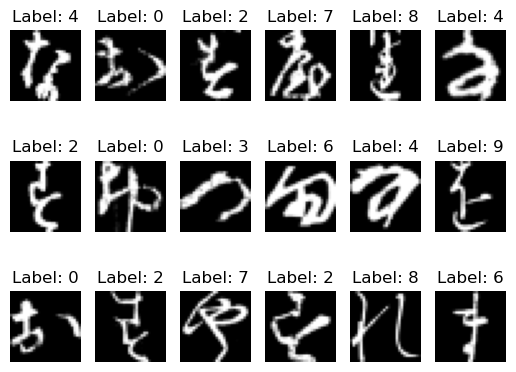

In [5]:
# Visualization of dataset
batch_idx, (data, target) = next(enumerate(train_loader, 0))
print(data.shape)

fig = plt.figure()
for i in range(18):
    plt.subplot(3, 6, i+1)
    plt.imshow(data[i][0], cmap='gray')
    plt.title('Label: {}'.format(target[i]))
    plt.axis(False)

### Add noise to data

In [6]:
def add_impulsive_noise(img, noise_prob=0.1):
    """
    Adding impulsive noise (salt and pepper) to the image.
    Args:
    - img (Tensor): A torch tensor representing the image.
    - noise_prob (float): Probability of adding noise to a pixel.
    Returns:
    - Tensor: Noisy image.
    """
    noise = torch.rand(img.size())
    img_noisy = img.clone()
    img_noisy[noise < noise_prob / 2] = 0  # salt noise
    img_noisy[noise > 1 - noise_prob / 2] = 1  # pepper noise
    return img_noisy

from torchvision.datasets import KMNIST

class NoisyKMNIST(KMNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, noise_prob=0.1):
        super(NoisyKMNIST, self).__init__(root, train=train, transform=transform, target_transform=target_transform, download=download)
        self.noise_prob = noise_prob

    def __getitem__(self, index):
        img, target = super(NoisyKMNIST, self).__getitem__(index)

        # Convert image to tenso
        if not isinstance(img, torch.Tensor):
            img = transforms.ToTensor()(img)

        # Create noisy image
        noisy_img = add_impulsive_noise(img, self.noise_prob)

        return noisy_img, target

In [7]:
# Define transforms for the original images (without noise addition)
original_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.1918,), (0.3483))])

# Create instances of the NoisyKMNIST dataset
noisy_train_dataset = NoisyKMNIST(root='./data', train=True, transform=original_transform, download=True, noise_prob=0.1)
noisy_test_dataset = NoisyKMNIST(root='./data', train=False, transform=original_transform, download=True, noise_prob=0.1)

In [8]:
# Create the dataloader 
noisy_train_loader = DataLoader(noisy_train_dataset, batch_size=batch_size, num_workers=0, sampler=train_sampler)
noisy_val_loader = DataLoader(noisy_train_dataset, batch_size=batch_size, num_workers=0, sampler=val_sampler)
noisy_test_loader = DataLoader(noisy_test_dataset, batch_size=len(test_dataset), num_workers=0, shuffle=True)


noisy_whole_train_loader = DataLoader(noisy_train_dataset,
                                batch_size=batch_size,
                                num_workers=0)

Noisy data shape: torch.Size([100, 1, 28, 28])


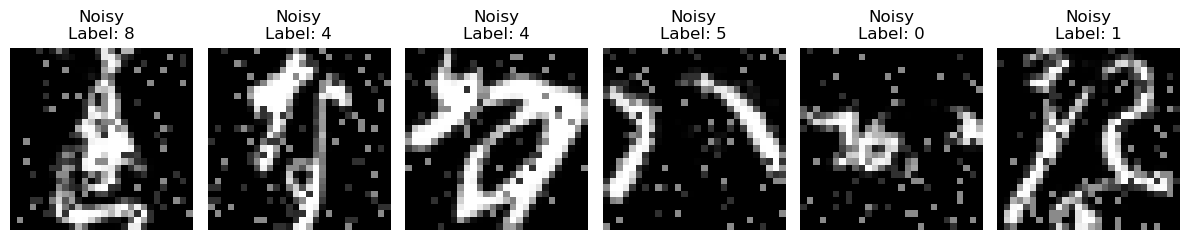

In [9]:
# Visualization of dataset
batch_idx, (noisy_data, target) = next(enumerate(noisy_train_loader, 0))
print("Noisy data shape:", noisy_data.shape)
# print("Clean data shape:", clean_data.shape)

fig = plt.figure(figsize=(12, 8))

for i in range(6):
    # Display noisy images
    plt.subplot(3, 6, i+1)
    plt.imshow(noisy_data[i][0], cmap='gray')
    plt.title('Noisy\nLabel: {}'.format(target[i]))
    plt.axis('off')

    # # Display clean images
    # plt.subplot(3, 6, i+7)
    # plt.imshow(clean_data[i][0], cmap='gray')
    # plt.title('Clean\nLabel: {}'.format(target[i]))
    # plt.axis('off')

plt.tight_layout()

## Autoencoder design

In [6]:
# Encoder
class Encoder(nn.Module):
    
    def __init__(self, bottleneck_size):
        '''
        bottleneck_size: dimension of features we encode
        '''
        super(Encoder, self).__init__()
        self.encode_dim = bottleneck_size
        # Hidden layer
        self.fc1 = nn.Linear(784, 800) ### 28 x 28 = 784
        self.bn1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.fc3 = nn.Linear(200, bottleneck_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    
# Decoder
class Decoder(nn.Module):
    
    def __init__(self, bottleneck_size):
        '''
        bottleneck_size: dimension of features we encode
        '''
        super(Decoder, self).__init__()
        self.encode_dim = bottleneck_size
        # Hidden layer
        self.fc1 = nn.Linear(bottleneck_size, 200)
        self.bn1 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, 800)
        self.bn2 = nn.BatchNorm1d(800)
        self.fc3 = nn.Linear(800, 784)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [7]:
# Validate the availibility of model
batch_idx, (data, target) = next(enumerate(train_loader))
encoder = Encoder(10)
decoder = Decoder(10)
bottleneck = encoder(data)
output = decoder(bottleneck)

In [8]:
# Structure of encoder(assume bottleneck is 10)
encoder = Encoder(10)
encoder = encoder.to(device)
summary(encoder, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 800]         628,000
       BatchNorm1d-2                  [-1, 800]           1,600
            Linear-3                  [-1, 200]         160,200
       BatchNorm1d-4                  [-1, 200]             400
            Linear-5                   [-1, 10]           2,010
Total params: 792,210
Trainable params: 792,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 3.02
Estimated Total Size (MB): 3.04
----------------------------------------------------------------


In [9]:
# Structure of decoder
decoder = Decoder(10)
decoder = decoder.to(device)
summary(decoder, input_size=(10,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]           2,200
       BatchNorm1d-2                  [-1, 200]             400
            Linear-3                  [-1, 800]         160,800
       BatchNorm1d-4                  [-1, 800]           1,600
            Linear-5                  [-1, 784]         627,984
Total params: 792,984
Trainable params: 792,984
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 3.02
Estimated Total Size (MB): 3.05
----------------------------------------------------------------


### Define training function

In [32]:
# Training function for each epoch
def train_epoch(encoder, decoder, device, train_loader, criterion, optimizer, correntropy=False):
    encoder.train()
    decoder.train()
    train_loss = 0.0
    mse = nn.MSELoss()
    train_step = len(train_loader)
    for idx, (img, target) in enumerate(train_loader):
        # Set to device
        img, target = img.to(device), target.to(device)
        # Forward pass
        bottleneck = encoder(img)
        output = decoder(bottleneck)
        loss = criterion(output, img)
        # Backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if correntropy == False:
            train_loss += loss.item()
        else: 
            with torch.no_grad():
                mse_loss = mse(output, img)
                train_loss += mse_loss.item()
    return train_loss / train_step

# validation function for each epoch
def val_epoch(encoder, decoder, device, val_loader):
    encoder.eval()
    decoder.eval()
    criterion = nn.MSELoss()
    with torch.no_grad():
        # Define the lists to store the outputs for each batch
        conc_output = []
        conc_label = []
        for idx, (img, target) in enumerate(val_loader):
            # Set to device
            img, target = img.to(device), target.to(device)
            # Forward pass
            bottleneck = encoder(img)
            output = decoder(bottleneck)
            conc_output.append(output.cpu())
            conc_label.append(img.cpu())
        # Create a single tensor with all the values in the lists
        conc_output = torch.cat(conc_output)
        conc_label = torch.cat(conc_label)
        # Evaluate global loss
        val_loss = criterion(conc_output, conc_label)
    return val_loss.data

def ae_training(encoder, decoder, train_loader, val_loader, device, epochs, optimizer, criterion, early_stop=False, visualization=False, printer=True, correntropy=False):
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    train_lc, val_lc = [], []
    if printer:
        print('================================================================')
    for epoch in range(epochs):
        start = time.time()
        # Train in one epoch
        train_loss = train_epoch(encoder, decoder, device, train_loader, criterion, optimizer, correntropy=correntropy)
        end = time.time()
        train_lc.append(train_loss)
        
        # Validation in one epoch
        if val_loader != None:
            val_loss = val_epoch(encoder, decoder, device, val_loader)
            val_lc.append(val_loss)
        
        if printer:
            print('Epoch {}/{} (time usage: {:.4f}s):'.format(epoch+1, epochs, end - start))
            if val_loader != None:
                print('Train_Loss: {:.6f}; Val_Loss: {:.6f}'.format(train_loss, val_loss))
            else:
                print('Train_Loss: {:.6f}'.format(train_loss))
            print('================================================================')
    
    if visualization:
        plt.figure(figsize=(7, 5))
        plt.plot(train_lc, label='train loss')
        if val_loader != None:
            plt.plot(val_lc, label='validation Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.legend()
    
    if not val_loader:
        return train_lc
    return (train_lc, val_lc)

Epoch 1/10 (time usage: 6.9539s):
Train_Loss: 0.510705; Val_Loss: 0.440345
Epoch 2/10 (time usage: 14.1180s):
Train_Loss: 0.434763; Val_Loss: 0.412918
Epoch 3/10 (time usage: 6.8890s):
Train_Loss: 0.417253; Val_Loss: 0.402611
Epoch 4/10 (time usage: 6.9077s):
Train_Loss: 0.410480; Val_Loss: 0.398132
Epoch 5/10 (time usage: 6.8842s):
Train_Loss: 0.405726; Val_Loss: 0.394324
Epoch 6/10 (time usage: 6.8530s):
Train_Loss: 0.402638; Val_Loss: 0.394161
Epoch 7/10 (time usage: 6.8545s):
Train_Loss: 0.400560; Val_Loss: 0.389542
Epoch 8/10 (time usage: 6.8230s):
Train_Loss: 0.399329; Val_Loss: 0.387230
Epoch 9/10 (time usage: 6.7645s):
Train_Loss: 0.397711; Val_Loss: 0.386842
Epoch 10/10 (time usage: 6.9762s):
Train_Loss: 0.396383; Val_Loss: 0.384298


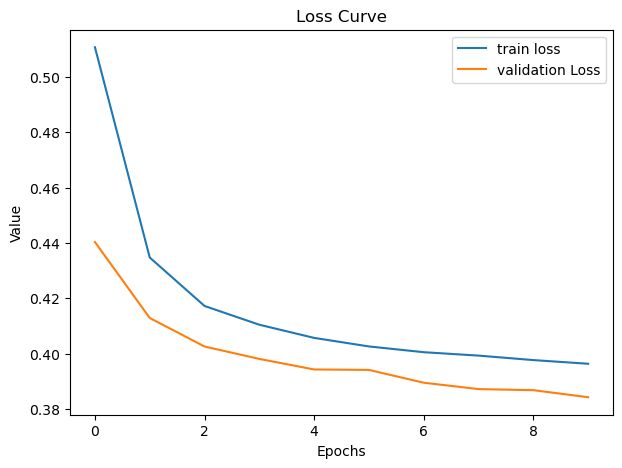

In [34]:
# Train autoencoder with size of bottleneck is 10
# Define the hyperparameter
bottleneck_size = 10
lr = 0.005
epochs = 10

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
encoder = Encoder(bottleneck_size)
decoder = Decoder(bottleneck_size)
parameter_to_optimize = [{'params': encoder.parameters()},
                         {'params': decoder.parameters()}]
criterion = nn.MSELoss()
optimizer = optim.Adam(parameter_to_optimize, lr=lr, weight_decay=1e-05)

# Training
history = ae_training(encoder,
                      decoder,
                      train_loader, 
                      val_loader,
                      device,
                      epochs,
                      optimizer,
                      criterion,
                      visualization=True)

## Hyperparameter tuning

### Experiment with size of bottleneck

For this project, our goal is to subspace the dataset and use it for classification. In this situation, it requests our reconstructed images don't have large loss and have smaller bottleneck size in the same time. Firstly, we will apply 4 sizes and see which interval performs best. Then we do concrete experiment in that interval to decide the best size of bottleneck:


In [123]:
# Define other hyperparameters
epochs = 80
lr = 0.003

# Define 4 points for first training, they are 10, 40, 70, 100
size_list = [10, 40, 70, 100]
history_experiment_bottleneck_1 = dict()
for bottleneck_size in size_list:
    torch.manual_seed(8)
    encoder = Encoder(bottleneck_size)
    decoder = Decoder(bottleneck_size)
    parameter_to_optimize = [{'params': encoder.parameters()},
                             {'params': decoder.parameters()}]
    criterion = nn.MSELoss()
    optimizer = optim.Adam(parameter_to_optimize, lr=lr, weight_decay=1e-05)

    # Training
    history = ae_training(encoder,
                          decoder,
                          train_loader, 
                          val_loader,
                          device,
                          epochs,
                          optimizer,
                          criterion,
                          visualization=False,
                          printer=False)
    
    history_experiment_bottleneck_1['bottleneck={}'.format(bottleneck_size)] = history

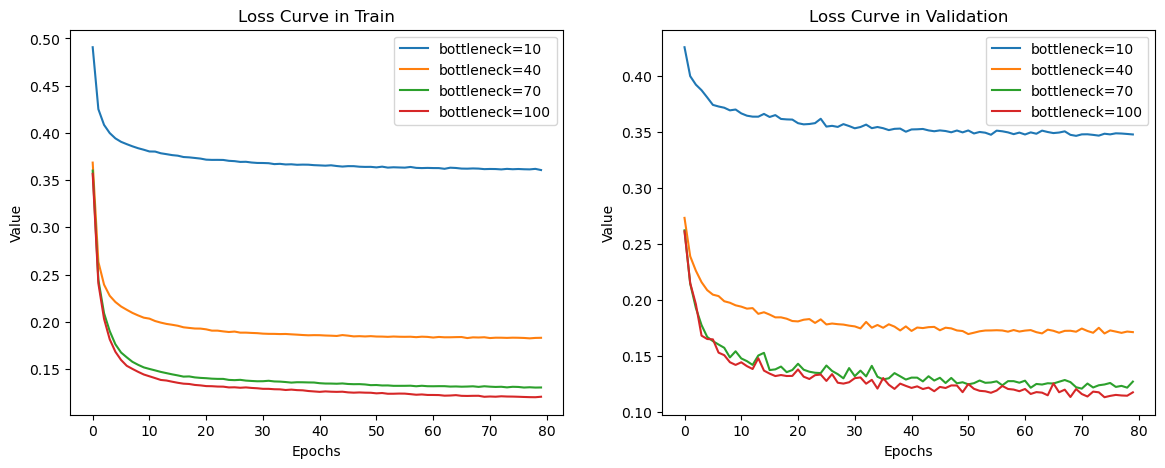

In [124]:
# Visualization of learning curve
plt.figure(figsize=(14, 5))
for key, (train_lc, val_lc) in history_experiment_bottleneck_1.items():
    plt.subplot(121)
    plt.plot(train_lc, label=key)
    plt.title('Loss Curve in Train')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(val_lc, label=key)
    plt.title('Loss Curve in Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
plt.show()

From figure above, we can see the bottleneck size between 10 to 40 has a huge loss gap. And for bottleneck size 40, the MSE is low and it is sufficient to use it to do the classification.However, we still have space to test the size between 10 and 40. This is the next step of our experiment.

In [125]:
# Define other hyperparameters
epochs = 80
lr = 0.003

# Define 6 points for interval [10, 40]
size_list = [15, 20, 25, 30, 35, 40]
history_experiment_bottleneck_2 = dict()
for bottleneck_size in size_list:
    torch.manual_seed(8)
    encoder = Encoder(bottleneck_size)
    decoder = Decoder(bottleneck_size)
    parameter_to_optimize = [{'params': encoder.parameters()},
                             {'params': decoder.parameters()}]
    criterion = nn.MSELoss()
    optimizer = optim.Adam(parameter_to_optimize, lr=lr, weight_decay=1e-05)

    # Training
    history = ae_training(encoder,
                          decoder,
                          train_loader, 
                          val_loader,
                          device,
                          epochs,
                          optimizer,
                          criterion,
                          visualization=False,
                          printer=False)
    
    history_experiment_bottleneck_2['bottleneck={}'.format(bottleneck_size)] = history

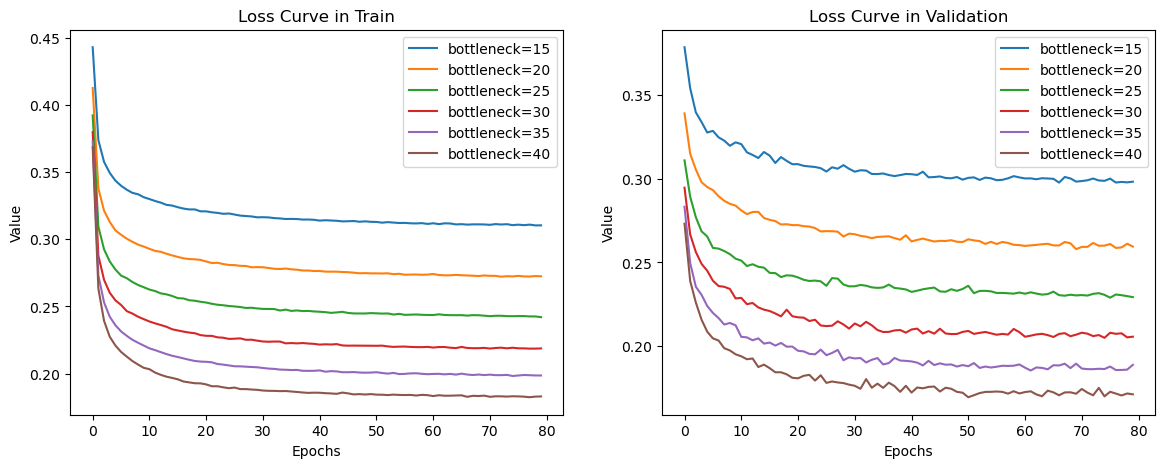

In [126]:
# Visualization of learning curve
plt.figure(figsize=(14, 5))
for key, (train_lc, val_lc) in history_experiment_bottleneck_2.items():
    plt.subplot(121)
    plt.plot(train_lc, label=key)
    plt.title('Loss Curve in Train')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(val_lc, label=key)
    plt.title('Loss Curve in Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
plt.show()

From the figures above, we can find that bottleneck size 10 has high loss and bottleneck size 100 is too large. There is no big difference in loss between 70 and 100, so we choose 70. However, we still have space to test the size between 40 and 70. This is the next step of our experiment.

In [12]:
# Define other hyperparameters
epochs = 80
lr = 0.003

# Define 6 points for interval [40, 70]
size_list = [40, 45, 50, 55, 60, 65, 70]
history_experiment_bottleneck_3 = dict()
for bottleneck_size in size_list:
    torch.manual_seed(8)
    encoder = Encoder(bottleneck_size)
    decoder = Decoder(bottleneck_size)
    parameter_to_optimize = [{'params': encoder.parameters()},
                             {'params': decoder.parameters()}]
    criterion = nn.MSELoss()
    optimizer = optim.Adam(parameter_to_optimize, lr=lr, weight_decay=1e-05)

    # Training
    history = ae_training(encoder,
                          decoder,
                          train_loader, 
                          val_loader,
                          device,
                          epochs,
                          optimizer,
                          criterion,
                          visualization=False,
                          printer=False)
    
    history_experiment_bottleneck_3['bottleneck={}'.format(bottleneck_size)] = history

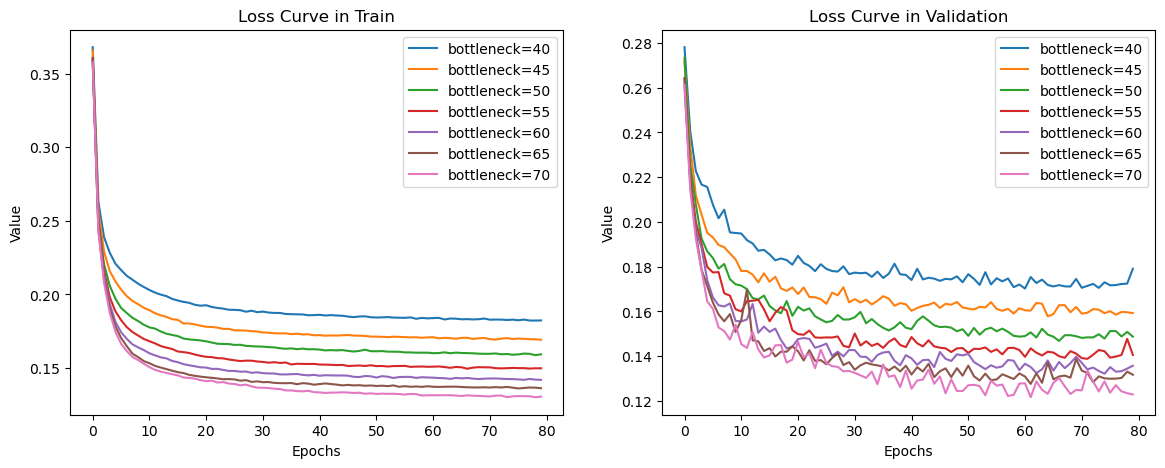

<Figure size 640x480 with 0 Axes>

In [14]:
# Visualization of learning curve
plt.figure(figsize=(14, 5))
for key, (train_lc, val_lc) in history_experiment_bottleneck_3.items():
    plt.subplot(121)
    plt.plot(train_lc, label=key)
    plt.title('Loss Curve in Train')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(val_lc, label=key)
    plt.title('Loss Curve in Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
plt.show()
plt.savefig('./figure/bottleneck [40 70].png')

Finally, we'd like a bottleneck size that have loss under 0.15 and small enough at same time. From figure above, we pick 60 as our final bottleneck size.

### Experiment with learning rate

We apply same strategy to pick the learning rate. Firstly, we will choose 5 points to test.

In [16]:
# Define other hyperparameters
epochs = 80
bottleneck_size = 60

# Define 4 points for first training, they are 10, 40, 70, 100
point_list = [0.05, 0.01, 0.005, 0.001, 0.0001]
history_experiment_lr_1 = dict()
for lr in point_list:
    torch.manual_seed(8)
    encoder = Encoder(bottleneck_size)
    decoder = Decoder(bottleneck_size)
    parameter_to_optimize = [{'params': encoder.parameters()},
                             {'params': decoder.parameters()}]
    criterion = nn.MSELoss()
    optimizer = optim.Adam(parameter_to_optimize, lr=lr, weight_decay=1e-05)

    # Training
    history = ae_training(encoder,
                          decoder,
                          train_loader, 
                          val_loader,
                          device,
                          epochs,
                          optimizer,
                          criterion,
                          visualization=False,
                          printer=False)
    
    history_experiment_lr_1['lr={}'.format(lr)] = history

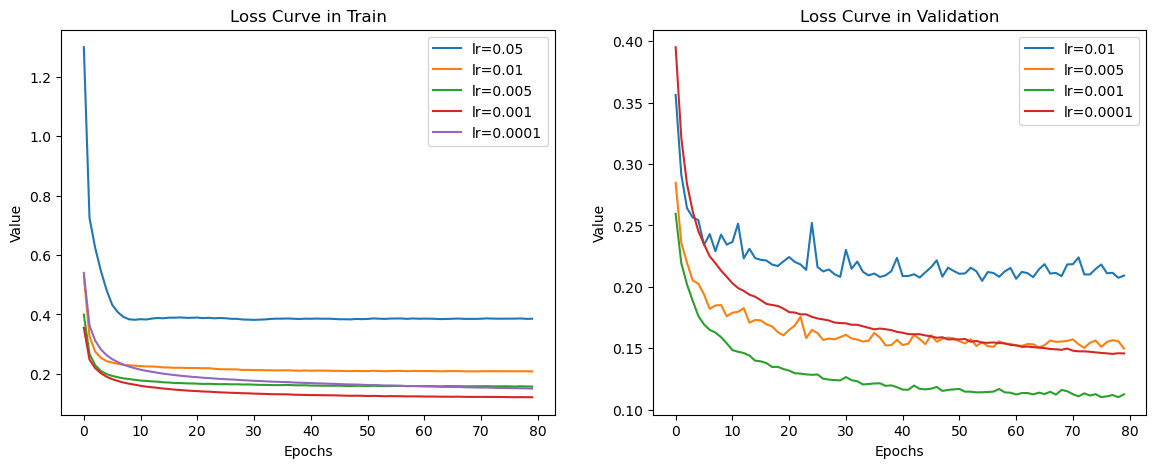

<Figure size 640x480 with 0 Axes>

In [20]:
# Visualization of learning curve
plt.figure(figsize=(14, 5))
for key, (train_lc, val_lc) in history_experiment_lr_1.items():
    plt.subplot(121)
    plt.plot(train_lc, label=key)
    plt.title('Loss Curve in Train')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    plt.subplot(122)
    if key != 'lr=0.05':
        plt.plot(val_lc, label=key)
        plt.title('Loss Curve in Validation')
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.legend()
plt.show()
plt.savefig('./figure/lr [0.05, 0.01, 0.005, 0.001, 0.0001].png')

0.01 is to large, and 0.0001 takes time to converge. Interval [0.001, 0.0001] would be our next experiment subject.

In [21]:
# Define other hyperparameters
epochs = 80
bottleneck_size = 60

# Define 4 points for first training, they are 10, 40, 70, 100
point_list = [ 0.001, 0.0008, 0.0006, 0.0005, 0.0003]
history_experiment_lr_2 = dict()
for lr in point_list:
    torch.manual_seed(8)
    encoder = Encoder(bottleneck_size)
    decoder = Decoder(bottleneck_size)
    parameter_to_optimize = [{'params': encoder.parameters()},
                             {'params': decoder.parameters()}]
    criterion = nn.MSELoss()
    optimizer = optim.Adam(parameter_to_optimize, lr=lr, weight_decay=1e-05)

    # Training
    history = ae_training(encoder,
                          decoder,
                          train_loader, 
                          val_loader,
                          device,
                          epochs,
                          optimizer,
                          criterion,
                          visualization=False,
                          printer=False)
    
    history_experiment_lr_2['lr={}'.format(lr)] = history

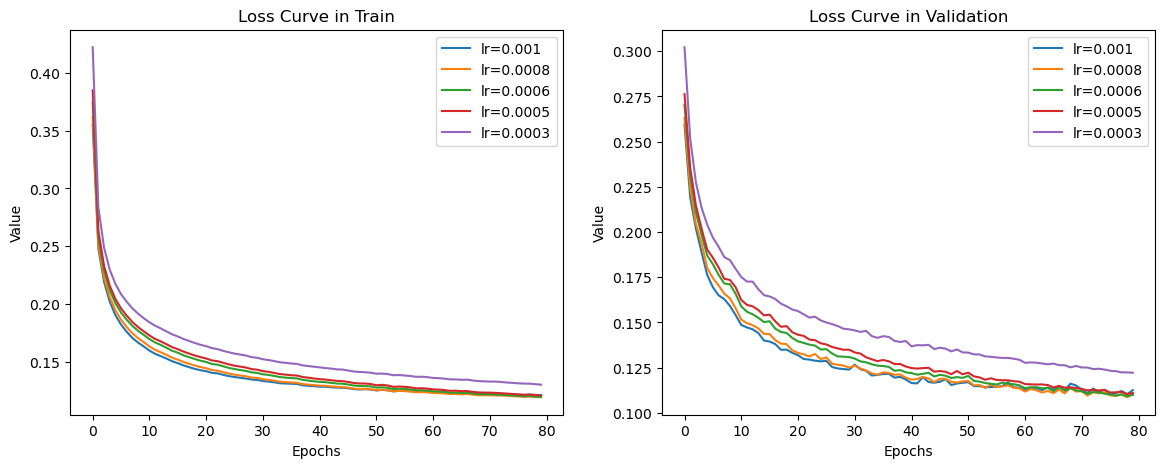

<Figure size 640x480 with 0 Axes>

In [22]:
# Visualization of learning curve
plt.figure(figsize=(14, 5))
for key, (train_lc, val_lc) in history_experiment_lr_2.items():
    plt.subplot(121)
    plt.plot(train_lc, label=key)
    plt.title('Loss Curve in Train')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(val_lc, label=key)
    plt.title('Loss Curve in Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
plt.show()
plt.savefig('./figure/lr [0.001, 0.0001].png')

Finally, we decided our model to use bottleneck size in 60 and learning rate in 0.0008

### Experiment with correntropy and kernal size

In [31]:
class CorrentropyLoss(nn.Module):
    def __init__(self, sigma=0.1):
        super(CorrentropyLoss, self).__init__()
        self.sigma = sigma

    def forward(self, inputs, targets):
        gauss_kernel = torch.exp(-((inputs - targets) ** 2) / (2 * self.sigma ** 2))
        return 1 - gauss_kernel.mean()


In [42]:
# # Train autoencoder with size of bottleneck is 10
# # Define the hyperparameter
# bottleneck_size = 60
# lr = 0.0008
# epochs = 10
# optimal_kernel_size=0.5

# # Define mapper, cost function and learing algorithm
# torch.manual_seed(8)
# encoder = Encoder(bottleneck_size)
# decoder = Decoder(bottleneck_size)
# parameter_to_optimize = [{'params': encoder.parameters()},
#                          {'params': decoder.parameters()}]
# criterion = CorrentropyLoss(sigma=optimal_kernel_size)
# optimizer = optim.Adam(parameter_to_optimize, lr=lr, weight_decay=1e-05)

# # Training
# history = ae_training(encoder,
#                       decoder,
#                       train_loader=noisy_train_loader, 
#                       val_loader=noisy_val_loader,
#                       device=device,
#                       epochs=epochs,
#                       optimizer=optimizer,
#                       criterion=criterion,
#                       visualization=True,
#                       correntropy=True)

Training with kernel size: 0.05
Training with kernel size: 0.2
Training with kernel size: 0.4
Training with kernel size: 0.6
Training with kernel size: 0.8
Training with kernel size: 1
Training with kernel size: 2
Training with kernel size: 5


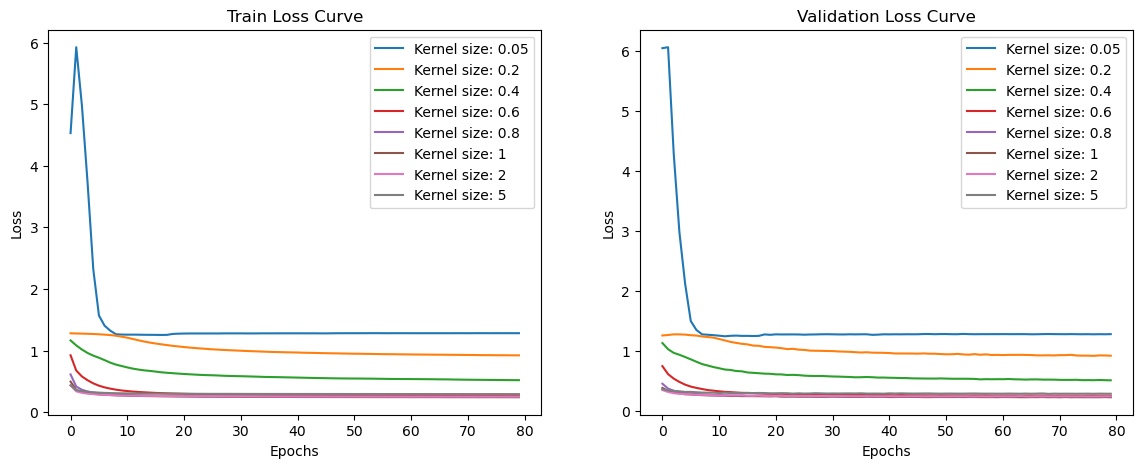

Best kernel size: 1


In [44]:
# Define hyperparameters
epochs = 80
lr = 0.0008   
bottleneck_size = 60 

# Kernel sizes to test
kernel_sizes = [0.05, 0.2, 0.4, 0.6, 0.8, 1, 2, 5]
history_kernel_size = dict()

# Iterate over different kernel sizes
for sigma in kernel_sizes:
    print(f"Training with kernel size: {sigma}")
    criterion = CorrentropyLoss(sigma=sigma)

    # Initialize encoder and decoder with the selected bottleneck size
    encoder = Encoder(bottleneck_size)
    decoder = Decoder(bottleneck_size)
    
    # Optimizer setup
    optimizer = optim.Adam([{'params': encoder.parameters()}, {'params': decoder.parameters()}], lr=lr, weight_decay=1e-05)
    
    # Training
    history = ae_training(encoder, decoder, noisy_train_loader, noisy_val_loader, device, epochs, optimizer, criterion, visualization=False, printer=False, correntropy=True)
    history_kernel_size[sigma] = history

# Visualization of learning curve for different kernel sizes
plt.figure(figsize=(14, 5))
for sigma, (train_lc, val_lc) in history_kernel_size.items():
    plt.subplot(121)
    plt.plot(train_lc, label=f'Kernel size: {sigma}')
    plt.title('Train Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(122)
    plt.plot(val_lc, label=f'Kernel size: {sigma}')
    plt.title('Validation Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# Determine the best kernel size based on validation loss
best_kernel_size = min(history_kernel_size, key=lambda k: min(history_kernel_size[k][1]))
print(f"Best kernel size: {best_kernel_size}")


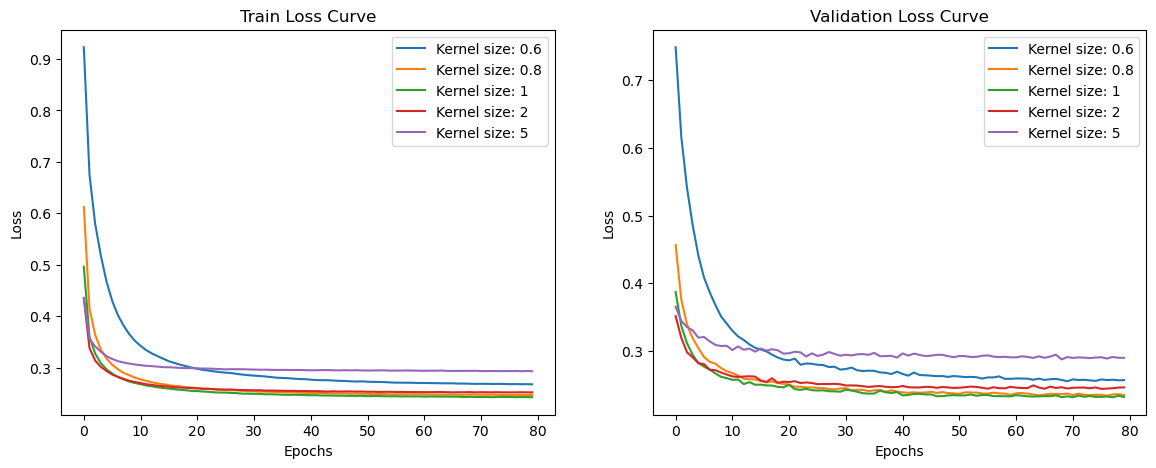

Best kernel size: 1


In [46]:
plt.figure(figsize=(14, 5))
for sigma, (train_lc, val_lc) in history_kernel_size.items():
    plt.subplot(121)
    if sigma > 0.5: 
        plt.plot(train_lc, label=f'Kernel size: {sigma}')
        plt.title('Train Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(122)
        plt.plot(val_lc, label=f'Kernel size: {sigma}')
        plt.title('Validation Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
plt.show()

# Determine the best kernel size based on validation loss
best_kernel_size = min(history_kernel_size, key=lambda k: min(history_kernel_size[k][1]))
print(f"Best kernel size: {best_kernel_size}")

Training with kernel size: 0.8
Training with kernel size: 0.9
Training with kernel size: 1
Training with kernel size: 1.1
Training with kernel size: 1.2
Training with kernel size: 1.3


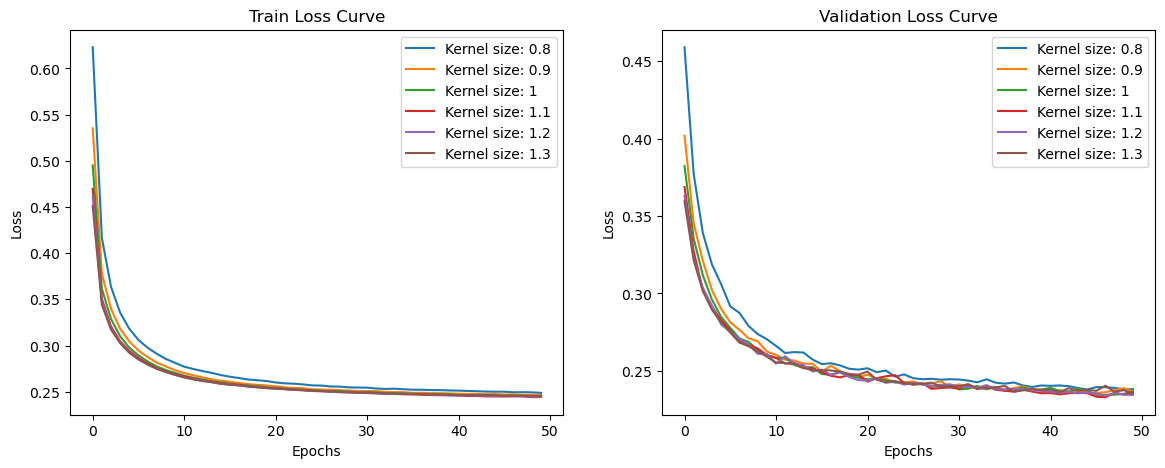

Best kernel size: 1.1


In [48]:
# Define hyperparameters
epochs = 50
lr = 0.0008   
bottleneck_size = 60 

# Kernel sizes to test
kernel_sizes = [0.8, 0.9, 1, 1.1, 1.2, 1.3]
history_kernel_size_2 = dict()

# Iterate over different kernel sizes
for sigma in kernel_sizes:
    print(f"Training with kernel size: {sigma}")
    criterion = CorrentropyLoss(sigma=sigma)

    # Initialize encoder and decoder with the selected bottleneck size
    encoder = Encoder(bottleneck_size)
    decoder = Decoder(bottleneck_size)
    
    # Optimizer setup
    optimizer = optim.Adam([{'params': encoder.parameters()}, {'params': decoder.parameters()}], lr=lr, weight_decay=1e-05)
    
    # Training
    history = ae_training(encoder, decoder, noisy_train_loader, noisy_val_loader, device, epochs, optimizer, criterion, visualization=False, printer=False, correntropy=True)
    history_kernel_size_2[sigma] = history

# Visualization of learning curve for different kernel sizes
plt.figure(figsize=(14, 5))
for sigma, (train_lc, val_lc) in history_kernel_size_2.items():
    plt.subplot(121)
    plt.plot(train_lc, label=f'Kernel size: {sigma}')
    plt.title('Train Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(122)
    plt.plot(val_lc, label=f'Kernel size: {sigma}')
    plt.title('Validation Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# Determine the best kernel size based on validation loss
best_kernel_size = min(history_kernel_size_2, key=lambda k: min(history_kernel_size_2[k][1]))
print(f"Best kernel size: {best_kernel_size}")

## Train model use best hyperparameters

### Train use clean dataset

Epoch 1/80 (time usage: 7.5708s):
Train_Loss: 0.348450
Epoch 2/80 (time usage: 7.2867s):
Train_Loss: 0.240938
Epoch 3/80 (time usage: 7.3188s):
Train_Loss: 0.213367
Epoch 4/80 (time usage: 7.4942s):
Train_Loss: 0.198026
Epoch 5/80 (time usage: 7.3149s):
Train_Loss: 0.187695
Epoch 6/80 (time usage: 7.3577s):
Train_Loss: 0.180044
Epoch 7/80 (time usage: 7.3780s):
Train_Loss: 0.174078
Epoch 8/80 (time usage: 7.2952s):
Train_Loss: 0.169215
Epoch 9/80 (time usage: 7.3601s):
Train_Loss: 0.165146
Epoch 10/80 (time usage: 7.3739s):
Train_Loss: 0.161649
Epoch 11/80 (time usage: 7.3583s):
Train_Loss: 0.158585
Epoch 12/80 (time usage: 7.2127s):
Train_Loss: 0.155888
Epoch 13/80 (time usage: 7.3784s):
Train_Loss: 0.153495
Epoch 14/80 (time usage: 7.2520s):
Train_Loss: 0.151329
Epoch 15/80 (time usage: 7.2396s):
Train_Loss: 0.149384
Epoch 16/80 (time usage: 7.3036s):
Train_Loss: 0.147619
Epoch 17/80 (time usage: 7.4378s):
Train_Loss: 0.146015
Epoch 18/80 (time usage: 7.3707s):
Train_Loss: 0.144530
E

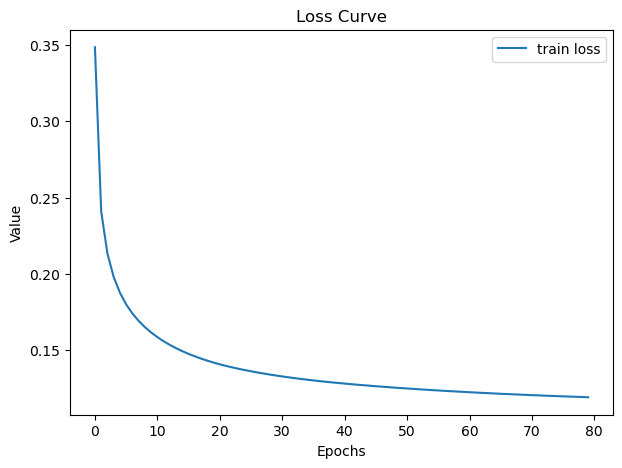

In [28]:
# Train autoencoder with size of bottleneck is 60
# Define the hyperparameter
bottleneck_size = 60
lr = 0.0008
epochs = 80

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
encoder = Encoder(bottleneck_size)
decoder = Decoder(bottleneck_size)
parameter_to_optimize = [{'params': encoder.parameters()},
                         {'params': decoder.parameters()}]
criterion = nn.MSELoss()
optimizer = optim.Adam(parameter_to_optimize, lr=lr, weight_decay=1e-05)

# Training
history = ae_training(encoder,
                      decoder,
                      train_loader=whole_train_loader, ### train with the whole training dataset in order to get the best performance
                      val_loader=None,
                      device=device,
                      epochs=epochs,
                      optimizer=optimizer,
                      criterion=criterion,
                      visualization=True)

In [30]:
# # Save the model
# torch.save(encoder.state_dict(), './models/encoder_weights.pth')
# torch.save(decoder.state_dict(), './models/decoder_weights.pth')

### Train with noisy dataset

#### Train with MSE

Epoch 1/80 (time usage: 15.5234s):
Train_Loss: 0.424820
Epoch 2/80 (time usage: 12.7950s):
Train_Loss: 0.331730
Epoch 3/80 (time usage: 13.5819s):
Train_Loss: 0.307685
Epoch 4/80 (time usage: 14.3381s):
Train_Loss: 0.294901
Epoch 5/80 (time usage: 14.9206s):
Train_Loss: 0.286392
Epoch 6/80 (time usage: 15.0272s):
Train_Loss: 0.280170
Epoch 7/80 (time usage: 15.2663s):
Train_Loss: 0.275311
Epoch 8/80 (time usage: 15.1818s):
Train_Loss: 0.271334
Epoch 9/80 (time usage: 14.6515s):
Train_Loss: 0.267816
Epoch 10/80 (time usage: 14.8574s):
Train_Loss: 0.265105
Epoch 11/80 (time usage: 14.3863s):
Train_Loss: 0.262399
Epoch 12/80 (time usage: 14.9433s):
Train_Loss: 0.260296
Epoch 13/80 (time usage: 14.9464s):
Train_Loss: 0.258331
Epoch 14/80 (time usage: 14.9993s):
Train_Loss: 0.256586
Epoch 15/80 (time usage: 14.6449s):
Train_Loss: 0.254930
Epoch 16/80 (time usage: 14.5358s):
Train_Loss: 0.253752
Epoch 17/80 (time usage: 14.5740s):
Train_Loss: 0.252361
Epoch 18/80 (time usage: 15.4008s):
Trai

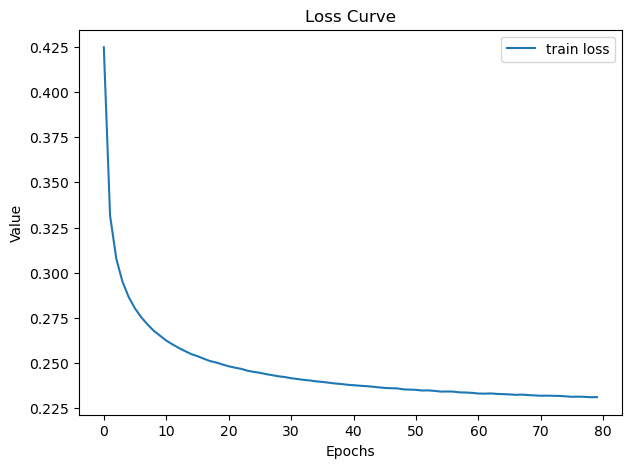

In [18]:
# Train autoencoder with size of bottleneck is 60
# Define the hyperparameter
bottleneck_size = 60
lr = 0.0008
epochs = 80

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
encoder = Encoder(bottleneck_size)
decoder = Decoder(bottleneck_size)
parameter_to_optimize = [{'params': encoder.parameters()},
                         {'params': decoder.parameters()}]
criterion = nn.MSELoss()
optimizer = optim.Adam(parameter_to_optimize, lr=lr, weight_decay=1e-05)

# Training
history = ae_training(encoder,
                      decoder,
                      train_loader=noisy_whole_train_loader, ### train with the whole training dataset in order to get the best performance
                      val_loader=None,
                      device=device,
                      epochs=epochs,
                      optimizer=optimizer,
                      criterion=criterion,
                      visualization=True)

In [49]:
# # Save the model
# torch.save(encoder.state_dict(), './models/noisy_encoder_weights.pth')
# torch.save(decoder.state_dict(), './models/noisy_decoder_weights.pth')

#### Train with correntropy

Epoch 1/50 (time usage: 15.9027s):
Train_Loss: 0.457680
Epoch 2/50 (time usage: 15.6527s):
Train_Loss: 0.341608
Epoch 3/50 (time usage: 15.3238s):
Train_Loss: 0.312093
Epoch 4/50 (time usage: 15.5170s):
Train_Loss: 0.296613
Epoch 5/50 (time usage: 15.4335s):
Train_Loss: 0.286610
Epoch 6/50 (time usage: 15.5796s):
Train_Loss: 0.279612
Epoch 7/50 (time usage: 15.6264s):
Train_Loss: 0.274274
Epoch 8/50 (time usage: 15.3499s):
Train_Loss: 0.270274
Epoch 9/50 (time usage: 15.4408s):
Train_Loss: 0.266880
Epoch 10/50 (time usage: 15.5953s):
Train_Loss: 0.264533
Epoch 11/50 (time usage: 15.3753s):
Train_Loss: 0.262148
Epoch 12/50 (time usage: 15.5720s):
Train_Loss: 0.260485
Epoch 13/50 (time usage: 15.4185s):
Train_Loss: 0.258890
Epoch 14/50 (time usage: 15.2862s):
Train_Loss: 0.257464
Epoch 15/50 (time usage: 15.5279s):
Train_Loss: 0.256278
Epoch 16/50 (time usage: 15.5838s):
Train_Loss: 0.255367
Epoch 17/50 (time usage: 15.5636s):
Train_Loss: 0.254373
Epoch 18/50 (time usage: 15.5000s):
Trai

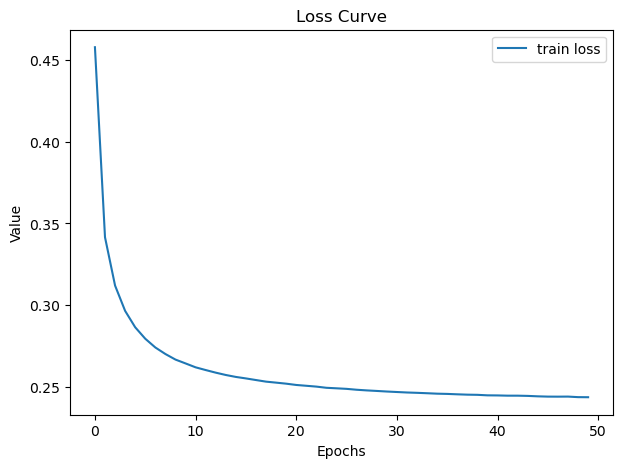

In [50]:
# Train autoencoder with size of bottleneck is 60, kernal_size=1.1
# Define the hyperparameter
bottleneck_size = 60
lr = 0.0008
epochs = 50
optimal_kernel_size=1.1

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
encoder = Encoder(bottleneck_size)
decoder = Decoder(bottleneck_size)
parameter_to_optimize = [{'params': encoder.parameters()},
                         {'params': decoder.parameters()}]
criterion = CorrentropyLoss(sigma=optimal_kernel_size)
optimizer = optim.Adam(parameter_to_optimize, lr=lr, weight_decay=1e-05)

# Training
history = ae_training(encoder,
                      decoder,
                      train_loader=noisy_whole_train_loader, ### train with the whole training dataset in order to get the best performance
                      val_loader=None,
                      device=device,
                      epochs=epochs,
                      optimizer=optimizer,
                      criterion=criterion,
                      visualization=True,
                      correntropy=True)

In [51]:
# Save the model
torch.save(encoder.state_dict(), './models/noisy_encoder_corr_weights.pth')
torch.save(decoder.state_dict(), './models/noisy_decoder_corr_weights.pth')

## Classification

### SAE + Classifier

In [33]:
# Design MLP for classification

class MLPClassifier(nn.Module):
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(60, 800)
        self.bn1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


In [35]:
# Define function for training classifier
# Training function for each epoch
def train_epoch(encoder, classifier, device, train_loader, criterion, optimizer):
    classifier.train()
    train_loss = 0.0
    train_correct = 0
    train_step = len(train_loader)
    for idx, (img, target) in enumerate(train_loader):
        # Set to device
        img, target = img.to(device), target.to(device)
        # Forward pass
        bottleneck = encoder(img)
        output = classifier(bottleneck)
        loss = criterion(output, target)
        # Backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        train_correct += (predicted == target).sum().item()
    return train_loss/train_step, train_correct/len(train_loader.sampler)*100

# validation function for each epoch
def val_epoch(encoder, classifier, device, val_loader, criterion):
    classifier.eval()
    val_step = len(val_loader)
    with torch.no_grad():
        # Define the lists to store the outputs for each batch
        val_loss = 0.0
        val_correct = 0.0
        total = 0.0
        for idx, (img, target) in enumerate(val_loader):
            # Set to device
            img, target = img.to(device), target.to(device)
            # Forward pass
            bottleneck = encoder(img)
            output = classifier(bottleneck)
            # Update loss and accuracy
            loss = criterion(output, target)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            val_correct += (predicted == target).sum().item()
            val_loss += loss.item()
    return val_loss/val_step, 100.0 * val_correct / total

# Training function
def classifier_training(encoder, classifier, train_loader, val_loader, device, epochs, optimizer, criterion, early_stop=False, visualization=False, printer=True):
    encoder = encoder.to(device)
    classifier = classifier.to(device)
    # Disable gradient computation for encoder 
    for param in encoder.parameters():
        param.requires_grad = False
    train_lc, val_lc = [], []
    train_acc, val_acc = [], []
    if printer:
        print('================================================================')
    for epoch in range(epochs):
        start = time.time()
        # Train in one epoch
        train_loss, train_correct = train_epoch(encoder, classifier, device, train_loader, criterion, optimizer)
        end = time.time()
        train_lc.append(train_loss)
        train_acc.append(train_correct)
        
        # Validation in one epoch
        if val_loader != None:
            val_loss, val_correct = val_epoch(encoder, classifier, device, val_loader, criterion)
            val_lc.append(val_loss)
            val_acc.append(val_correct)
        
        if printer:
            print('Epoch {}/{} (time usage: {:.4f}s):'.format(epoch+1, epochs, end - start))
            if val_loader != None:
                print('Loss: {:.6f}, Accuracy: {:.2f}%'.format(train_loss, train_correct))
                print('Val_Loss: {:.6f}, Val_Accuracy: {:.2f}%'.format(val_loss, val_correct))
            else:
                print('Loss: {:.6f}, Accuracy: {:.2f}%'.format(train_loss, train_correct))
            print('================================================================')
    
    if visualization:
        plt.figure(figsize=(14, 5))
        plt.subplot(121)
        plt.plot(train_lc, label='train loss')
        if val_loader != None:
            plt.plot(val_lc, label='validation Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.legend()

        plt.subplot(122)
        plt.plot(train_acc, label='train acc')
        if val_loader != None:
            plt.plot(val_acc, label='validation acc')
        plt.title('Accuracy Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Value / %')
        plt.legend()
    
    if not val_loader:
        return (train_lc, train_acc)
    return (train_lc, train_acc, val_lc, val_acc)

Epoch 1/60 (time usage: 8.8620s):
Loss: 0.326188, Accuracy: 90.69%
Epoch 2/60 (time usage: 7.4952s):
Loss: 0.122340, Accuracy: 96.47%
Epoch 3/60 (time usage: 7.4273s):
Loss: 0.070732, Accuracy: 98.12%
Epoch 4/60 (time usage: 7.7185s):
Loss: 0.041365, Accuracy: 99.04%
Epoch 5/60 (time usage: 7.3143s):
Loss: 0.025697, Accuracy: 99.45%
Epoch 6/60 (time usage: 7.3554s):
Loss: 0.027748, Accuracy: 99.22%
Epoch 7/60 (time usage: 7.4903s):
Loss: 0.023414, Accuracy: 99.30%
Epoch 8/60 (time usage: 7.2951s):
Loss: 0.015572, Accuracy: 99.57%
Epoch 9/60 (time usage: 7.4503s):
Loss: 0.012813, Accuracy: 99.66%
Epoch 10/60 (time usage: 7.5771s):
Loss: 0.015346, Accuracy: 99.55%
Epoch 11/60 (time usage: 7.6034s):
Loss: 0.010544, Accuracy: 99.71%
Epoch 12/60 (time usage: 7.5530s):
Loss: 0.014168, Accuracy: 99.54%
Epoch 13/60 (time usage: 7.5471s):
Loss: 0.013566, Accuracy: 99.60%
Epoch 14/60 (time usage: 7.5777s):
Loss: 0.006862, Accuracy: 99.85%
Epoch 15/60 (time usage: 7.5264s):
Loss: 0.006390, Accura

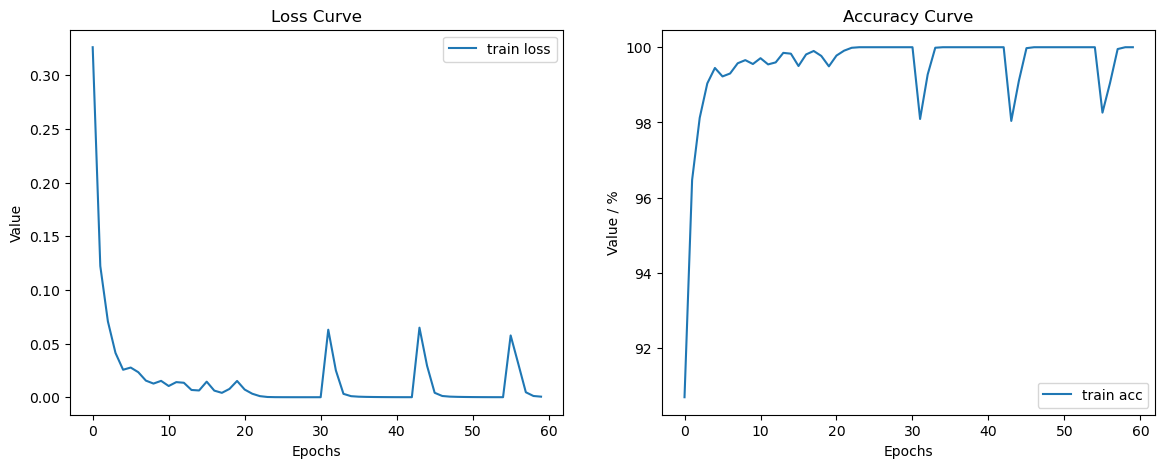

In [65]:
# Train classifier
# Define the hyperparameter
lr = 0.0008
epochs = 60

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
encoder = Encoder(60)
encoder.load_state_dict(torch.load('./models/encoder_weights.pth'))
classifier = MLPClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=lr, weight_decay=1e-05)

# Training
history = classifier_training(encoder,
                              classifier,
                              train_loader=whole_train_loader, 
                              val_loader=None,
                              device=device,
                              epochs=epochs,
                              optimizer=optimizer,
                              criterion=criterion,
                              visualization=True)

In [75]:
class CombinedClassifier(nn.Module):
    def __init__(self, encoder, classifier):
        super(CombinedClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = classifier

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x
    
sae_mlp_classifier = CombinedClassifier(encoder, classifier)

In [76]:
## save the model
# torch.save(classifier.state_dict(), './models/mlp_classifier_after_encoder_weights_.pth')
# torch.save(sae_mlp_classifier.state_dict(), './models/sae_mlp_classifier_weights.pth')

### MLP model from project 1

In [67]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.flatten = nn.Flatten()

        # First hidden layer: 784 -> 512
        self.fc1 = nn.Linear(784, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')

        # Second hidden layer: 512 -> 256
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')

        # Output layer: 256 -> 10
        self.fc3 = nn.Linear(256, 10)
        init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')

    def forward(self, x):
        x = self.flatten(x)
        
        # First hidden layer
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        # Second hidden layer
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        # Output layer
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

In [85]:
classifier_p1 = MLP()
classifier_p1.load_state_dict(torch.load('./models/mlp_classifier_weights_project1.pth')) 

<All keys matched successfully>

### Comparison

In [78]:
# Load the classifier in project 2
encoder = Encoder(60)
mlp_classsifier = MLPClassifier()
encoder.load_state_dict(torch.load('./models/encoder_weights.pth'))
mlp_classsifier.load_state_dict(torch.load('./models/mlp_classifier_after_encoder_weights_.pth'))

classifier_p2 = CombinedClassifier(encoder, mlp_classsifier)
classifier_p2.load_state_dict(torch.load('./models/sae_mlp_classifier_weights.pth'))

<All keys matched successfully>

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Define evaluation function for model
def eval_model(model, test_loader): 
    model = model.to(device)
    model.eval()
    true_labels = []
    predicted_labels = []
    test_probs = []
    
    with torch.no_grad():
        for idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            _, predicted = torch.max(output.data, 1)
            true_labels.extend(target.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            
    print('\nACCURACY: {}'.format(accuracy_score(true_labels, predicted_labels)))
    print('----------------------------------')
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(2)), yticklabels=list(range(2)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    


ACCURACY: 0.6674
----------------------------------


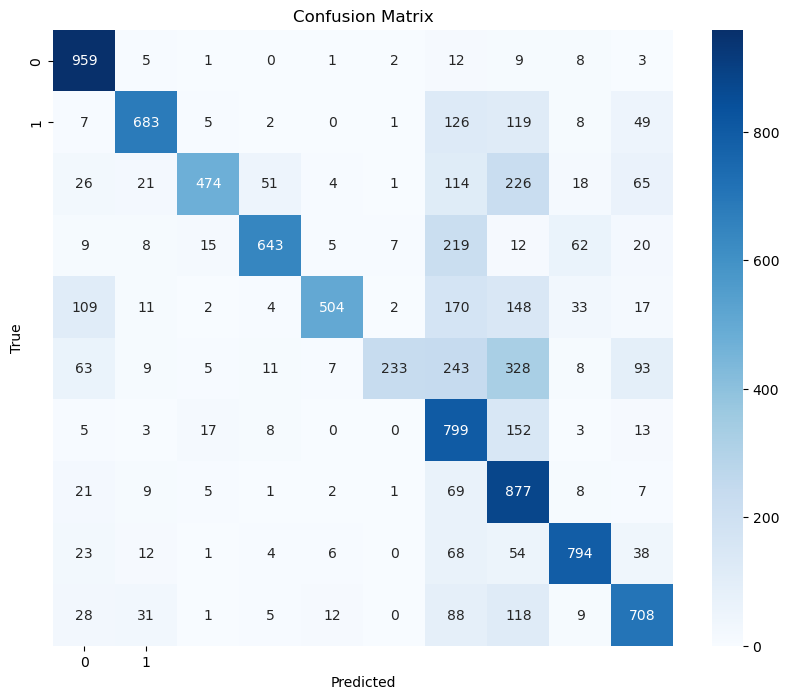

In [86]:
eval_model(classifier_p1, test_loader)


ACCURACY: 0.9311
----------------------------------


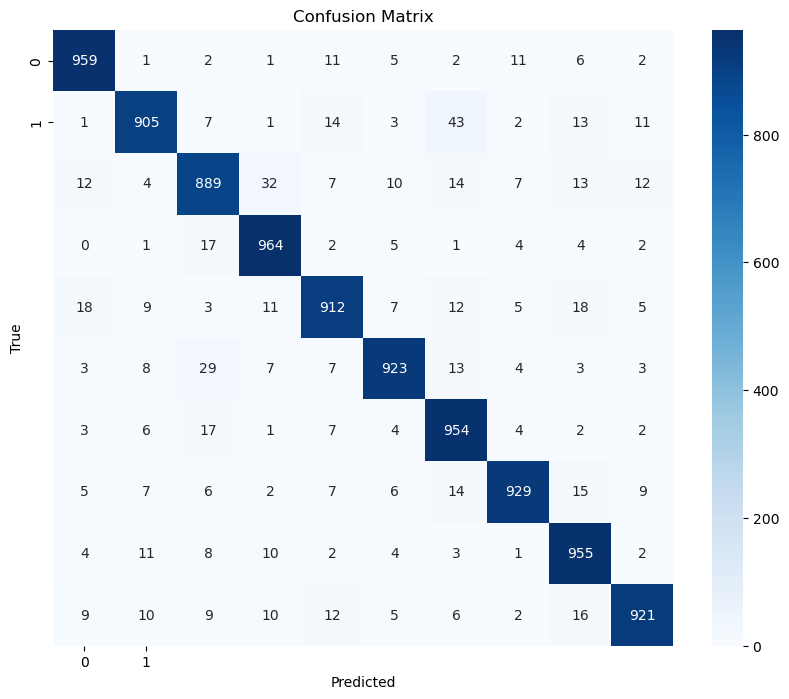

In [87]:
eval_model(classifier_p2, test_loader)

In [88]:
# Structure of project 1
summary(classifier_p1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
              ReLU-4                  [-1, 512]               0
           Dropout-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
       BatchNorm1d-7                  [-1, 256]             512
              ReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 537,354
Trainable params: 537,354
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.05
Estimated T

In [89]:
# Structure of encoder(assume bottleneck is 10)
summary(classifier_p2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 800]         628,000
       BatchNorm1d-2                  [-1, 800]           1,600
            Linear-3                  [-1, 200]         160,200
       BatchNorm1d-4                  [-1, 200]             400
            Linear-5                   [-1, 60]          12,060
           Encoder-6                   [-1, 60]               0
            Linear-7                  [-1, 800]          48,800
       BatchNorm1d-8                  [-1, 800]           1,600
            Linear-9                  [-1, 200]         160,200
      BatchNorm1d-10                  [-1, 200]             400
           Linear-11                   [-1, 10]           2,010
    MLPClassifier-12                   [-1, 10]               0
Total params: 1,015,270
Trainable params: 1,015,270
Non-trainable params: 0
---------------------------

### Classification with 10 bottleneck

Epoch 1/50 (time usage: 7.5841s):
Train_Loss: 0.487177
Epoch 2/50 (time usage: 7.2583s):
Train_Loss: 0.424401
Epoch 3/50 (time usage: 7.4608s):
Train_Loss: 0.405216
Epoch 4/50 (time usage: 7.2187s):
Train_Loss: 0.393597
Epoch 5/50 (time usage: 7.1865s):
Train_Loss: 0.385434
Epoch 6/50 (time usage: 7.1892s):
Train_Loss: 0.379285
Epoch 7/50 (time usage: 7.2606s):
Train_Loss: 0.374391
Epoch 8/50 (time usage: 7.2549s):
Train_Loss: 0.370326
Epoch 9/50 (time usage: 7.3749s):
Train_Loss: 0.366923
Epoch 10/50 (time usage: 7.2265s):
Train_Loss: 0.364012
Epoch 11/50 (time usage: 7.1412s):
Train_Loss: 0.361437
Epoch 12/50 (time usage: 7.2229s):
Train_Loss: 0.359177
Epoch 13/50 (time usage: 7.2399s):
Train_Loss: 0.357190
Epoch 14/50 (time usage: 7.2156s):
Train_Loss: 0.355345
Epoch 15/50 (time usage: 7.2258s):
Train_Loss: 0.353748
Epoch 16/50 (time usage: 7.2472s):
Train_Loss: 0.352221
Epoch 17/50 (time usage: 7.2008s):
Train_Loss: 0.350887
Epoch 18/50 (time usage: 7.2362s):
Train_Loss: 0.349666
E

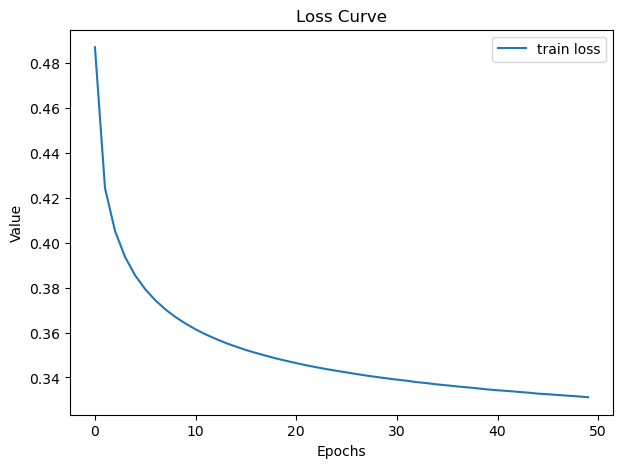

In [34]:
# Train autoencoder with size of bottleneck is 60
# Define the hyperparameter
bottleneck_size = 10
lr = 0.0008
epochs = 50

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
encoder = Encoder(bottleneck_size)
decoder = Decoder(bottleneck_size)
parameter_to_optimize = [{'params': encoder.parameters()},
                         {'params': decoder.parameters()}]
criterion = nn.MSELoss()
optimizer = optim.Adam(parameter_to_optimize, lr=lr, weight_decay=1e-05)

# Training
history = ae_training(encoder,
                      decoder,
                      train_loader=whole_train_loader, ### train with the whole training dataset in order to get the best performance
                      val_loader=None,
                      device=device,
                      epochs=epochs,
                      optimizer=optimizer,
                      criterion=criterion,
                      visualization=True)

In [36]:
# Design MLP for classification

class MLPClassifier(nn.Module):
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(10, 800)
        self.bn1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


Epoch 1/30 (time usage: 7.2609s):
Loss: 0.315858, Accuracy: 91.24%
Epoch 2/30 (time usage: 7.6991s):
Loss: 0.197032, Accuracy: 94.18%
Epoch 3/30 (time usage: 7.1751s):
Loss: 0.171983, Accuracy: 94.90%
Epoch 4/30 (time usage: 7.5471s):
Loss: 0.156531, Accuracy: 95.35%
Epoch 5/30 (time usage: 7.3899s):
Loss: 0.145617, Accuracy: 95.68%
Epoch 6/30 (time usage: 7.3944s):
Loss: 0.136843, Accuracy: 95.90%
Epoch 7/30 (time usage: 7.4275s):
Loss: 0.129267, Accuracy: 96.10%
Epoch 8/30 (time usage: 7.5139s):
Loss: 0.122479, Accuracy: 96.25%
Epoch 9/30 (time usage: 7.4734s):
Loss: 0.116635, Accuracy: 96.44%
Epoch 10/30 (time usage: 7.4683s):
Loss: 0.110879, Accuracy: 96.62%
Epoch 11/30 (time usage: 7.4274s):
Loss: 0.105653, Accuracy: 96.80%
Epoch 12/30 (time usage: 7.4785s):
Loss: 0.100806, Accuracy: 96.95%
Epoch 13/30 (time usage: 7.6659s):
Loss: 0.096269, Accuracy: 97.08%
Epoch 14/30 (time usage: 7.5629s):
Loss: 0.091925, Accuracy: 97.18%
Epoch 15/30 (time usage: 7.4332s):
Loss: 0.087358, Accura

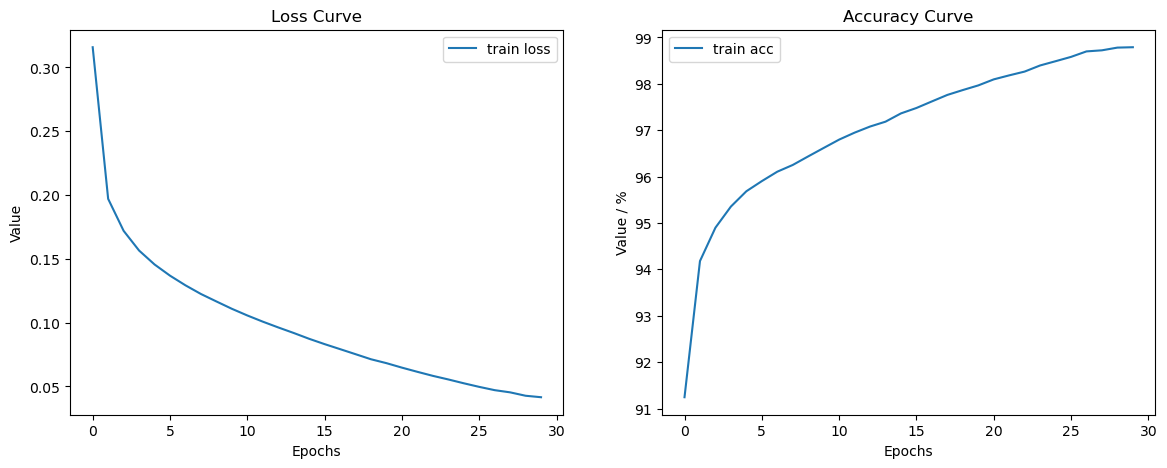

In [46]:
# Train classifier
# Define the hyperparameter
lr = 0.0008
epochs = 30

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
classifier = MLPClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=lr, weight_decay=1e-05)

# Training
history = classifier_training(encoder,
                              classifier,
                              train_loader=whole_train_loader, 
                              val_loader=None,
                              device=device,
                              epochs=epochs,
                              optimizer=optimizer,
                              criterion=criterion,
                              visualization=True)

In [47]:
class CombinedClassifier(nn.Module):
    def __init__(self, encoder, classifier):
        super(CombinedClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = classifier

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x
    
sae_mlp_classifier = CombinedClassifier(encoder, classifier)

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

def eval_model(model, test_loader): 
    model = model.to(device)
    model.eval()
    true_labels = []
    predicted_labels = []
    test_probs = []
    
    with torch.no_grad():
        for idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            _, predicted = torch.max(output.data, 1)
            true_labels.extend(target.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            
    print('\nACCURACY: {}'.format(accuracy_score(true_labels, predicted_labels)))
    print('----------------------------------')
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(2)), yticklabels=list(range(2)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


ACCURACY: 0.8755
----------------------------------


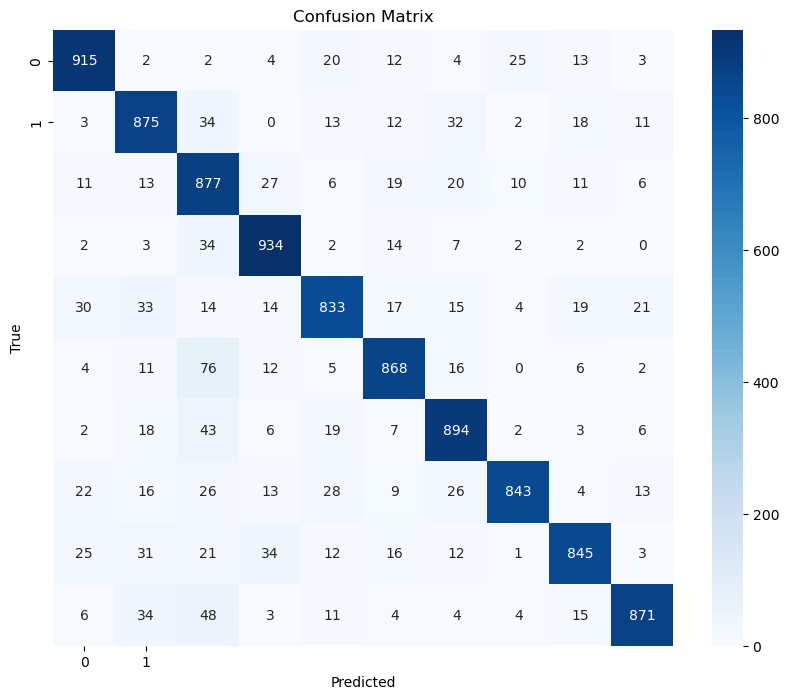

In [49]:
eval_model(sae_mlp_classifier, test_loader)